# EDSA - Climate Change Belief Analysis
#### Classification_TS3_DSFT21
<div style="width:100%;text-align: center;"> <img align=middle src="https://www.iberdrola.com/wcorp/gc/prod/en_US/comunicacion/adaptacion_cambio_climatico_mult_1_res/Adaptacion_746x419.jpg" alt="Heat beating" style="height:600px;margin-top:3rem;"> </div>

## Table of Contents

1. <a href ="#1.-Challenge-description">Challenge description</a>
2. <a href ="#2.-Introduction">Introduction</a>
3. <a href ="#3.-Importing-Libraries">Importing Libraries</a>
4. <a href ="#4.-Importing-Data">Importing Data</a>
5. <a href ="#5.-Exploratory-Data-Analysis">Exploratory Data Analysis</a>
6. <a href ="#6.-Data-Preprocessing">Data Preprocessing</a>
7. <a href ="#7.-Model-Building">Model Building</a>
8. <a href ="#8.-Model-Comparison">Model Comparison</a>
9. <a href ="#9.-Model-Optimisation">Model Optimisation</a>
10. <a href ="#10.-Conclusion">Conclusion</a>




# 1. Challenge description

Many companies are built around lessening one's environmental impact or carbon foot print. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climante change and whether or not they belive it is a real threat. This would add to their market research efforts in gaugin how their product/service may be received.

With this context, EDSA is challending us during the Classification Sprint with the task of creating a Machine Learning mode that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to the task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


# 2. Introduction

To achieve this, we shall perform preprocessing of the data, statistical and exploratory data analysis, construct multiple machine learning models, train our models with regards to the sentiment expressed by the user and of course testing our model on unseen data to verify the validity of our model.

# Start Comet Experiment

In [1]:
# import comet_ml at the top of your file
# from comet_ml import Experiment

# # Create an experiment with your api key
# experiment = Experiment(
#     api_key="d4LPbs6tjAyPaNQcw3NFP2a29",
#     project_name="ts3-classification",
#     workspace="rlatndgb",
#)

# 3. Importing Libraries

In this notebook we shall be importing various python libraries to assist with constructing our classification model.

In [2]:
import os
os.getcwd

import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud
import requests

import re
import emoji
from string import punctuation
from nltk import pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, f1_score

# set plot style
sns.set(style = 'whitegrid',font_scale=1.2)

# 4. Importing Data

In [3]:
#Training set
train_df = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/train.csv')
#Test set
test_df = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/test.csv')

## 4.1 Data Overview

Our training set consist of 3 columns:
* The sentiment : Indicates the sentiment of the tweet message
* message : The body of the tweet
* tweetid : Twitter unique id

In [4]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


We look at the top rows of our data to the see the features as well as the types of data we are working with.

In [5]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Let us get the dimensions of our data to figure out how many observations we have.

In [6]:
print("Train data: ", train_df.shape)
print("Test data: ", test_df.shape)

Train data:  (15819, 3)
Test data:  (10546, 2)


We have 15 819 Observations in our data.

Let us get the types of sentiments that are there and their descriptions.

In [7]:
list(train_df['sentiment'].unique())

[1, 2, 0, -1]

There are three class namely :
* 1 Pro: the tweet supports the belief of man-made climate
* 2 News: the tweet links to factual news about climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Let us investigate how the labels are distributed 

(-1.25, 1.25, -1.25, 1.25)

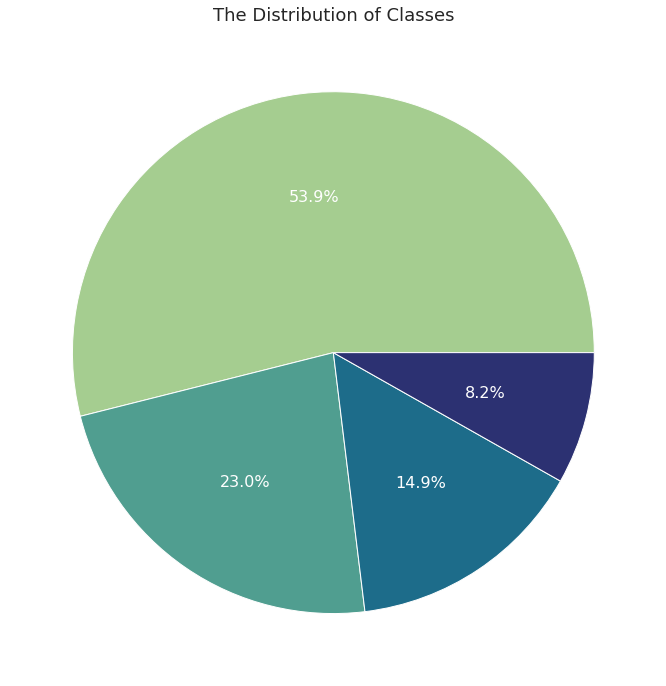

In [8]:

pie = train_df['sentiment'].value_counts().plot(kind='pie',
                                          figsize=(12,12),autopct='%1.1f%%', 
                                          colormap ='crest',fontsize=16,
                                          textprops={'color':"w"})
pie.set_title('The Distribution of Classes', fontsize=18)
plt.axis('off')


From the figure above, we observed that we have unbalanced classes. 
* The majority of tweets (53.9%/8530) support the belief of man-made climate change. 
* 23% consist of factual news regarding climate change. 
* 14.9% are neutral about man-made climate change
* 8.2% don't believe in man-made climate change

# 5.1. Exploratory Data Analysis

### Most Commonly Used Words
We investigated the attributes of our text data. We generated wordclouds to study the most occuring words in each of the following:


* All tweets
* Class -1: Anti-Climate Change
* Class 1: Pro Climate Change
* Class 0: Neutral Climate Change
* Class 2: News

The results from the investigation will inform how we clean our data and engineer our features

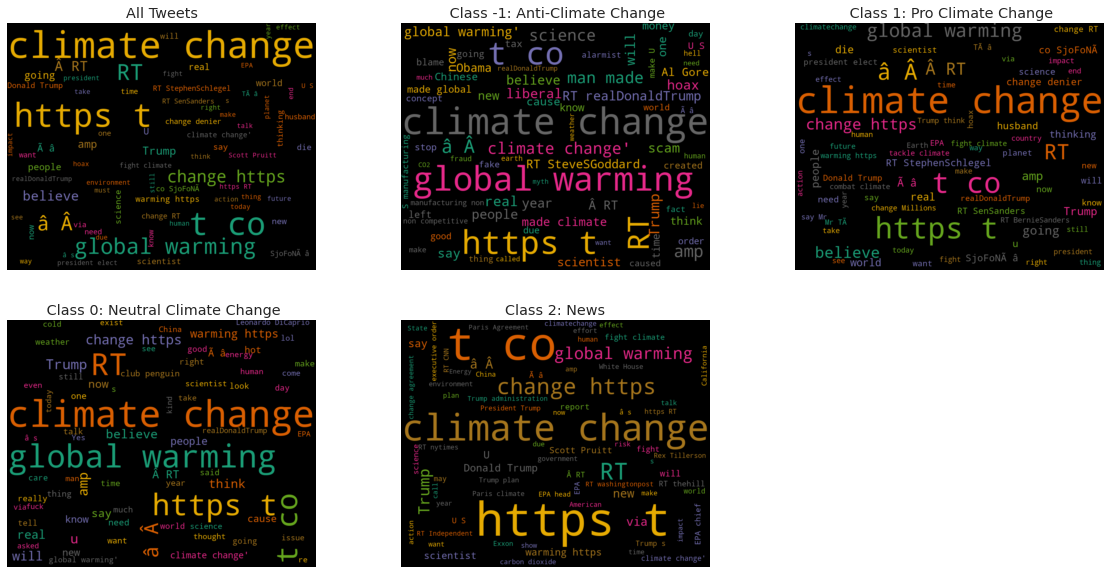

In [9]:
wc = WordCloud(height=800, width=1000, background_color="black",
               colormap="Dark2", max_font_size=150,
               random_state=42,max_words=75)

all_words = ' '.join([text for text in train_df['message']])
neg_words =' '.join([text for text in train_df['message'][train_df['sentiment'] == -1]])
pro_words = ' '.join([text for text in train_df['message'][train_df['sentiment'] == 1]])
neutral_words = ' '.join([text for text in train_df['message'][train_df['sentiment'] == 0]])
news = ' '.join([text for text in train_df['message'][train_df['sentiment'] == 2]])

classes =[all_words,neg_words,pro_words,neutral_words,news]

headings=["All Tweets",
          " Class -1: Anti-Climate Change",
         " Class 1: Pro Climate Change",
         " Class 0: Neutral Climate Change",
         "Class 2: News"]
plt.rcParams['figure.figsize'] = [20, 10]

c=1
for sentiment in classes:
    wc.generate(sentiment)
    plt.subplot(2, 3,c)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title((headings[c-1]))
    c+=1

plt.show()



- "climate change" and "global warming" are two of the most common words that appear in our dataset. This is not surprising as the dataset is collected on the tweets based on these terms.
<br>
- "https" is another popular word found in the tweet. This suggests that many tweets contain web links 
that may address the climate change topics and the widely shared among the general public
<br>
- Names of the controversial figures appear commonly in the tweets. The former president of the United States, Donald Trump and the Administrator of the U.S 
<br>

Environmental Protection Agency (EPA), Scott Pruitt are well-known for their rejection of scientific consensus on climate change. Contrastingly, senator Bernie Sanders, Al Gore and Leo DiCaprio are famous activist/advocates for man-made climate change. 

- Terms such as "Republican", "EPA", "Chinese", "America" occur frequently in the tweets, indicating that climate change is perceived as a political issue
<br>





## Hashtag & Mention Extraction
We are dealing with Tweeter data and attributes such as the most common hashtags and mentions may provide meanful insights. 

In [10]:
def hash_men_ext(col,rex):
    
    rex_dict={r"#(\w+)": "hashtag", r"@(\w+)": "Mention"}
    
    word_list = [re.findall(rex,i) for i in col]
    word_list_sum = sum(word_list, [])
    
    frequency = nltk.FreqDist(word_list_sum)
    
    word_list_df = pd.DataFrame({rex_dict[rex] :list(frequency.keys()),
                                "count": list(frequency.values())})
    top_ten_attr = word_list_df.nlargest(10, columns="count")
    
    return top_ten_attr         

### Hashtags

In [11]:
pro_has = hash_men_ext(train_df['message'][train_df['sentiment'] == 1],r"#(\w+)")
anti_has = hash_men_ext(train_df['message'][train_df['sentiment'] == -1],r"#(\w+)")
neutral_has = hash_men_ext(train_df['message'][train_df['sentiment'] == 0],r"#(\w+)")
news_has = hash_men_ext(train_df['message'][train_df['sentiment'] == 2],r"#(\w+)")

Text(0.5, 1.0, 'Class 2: News')

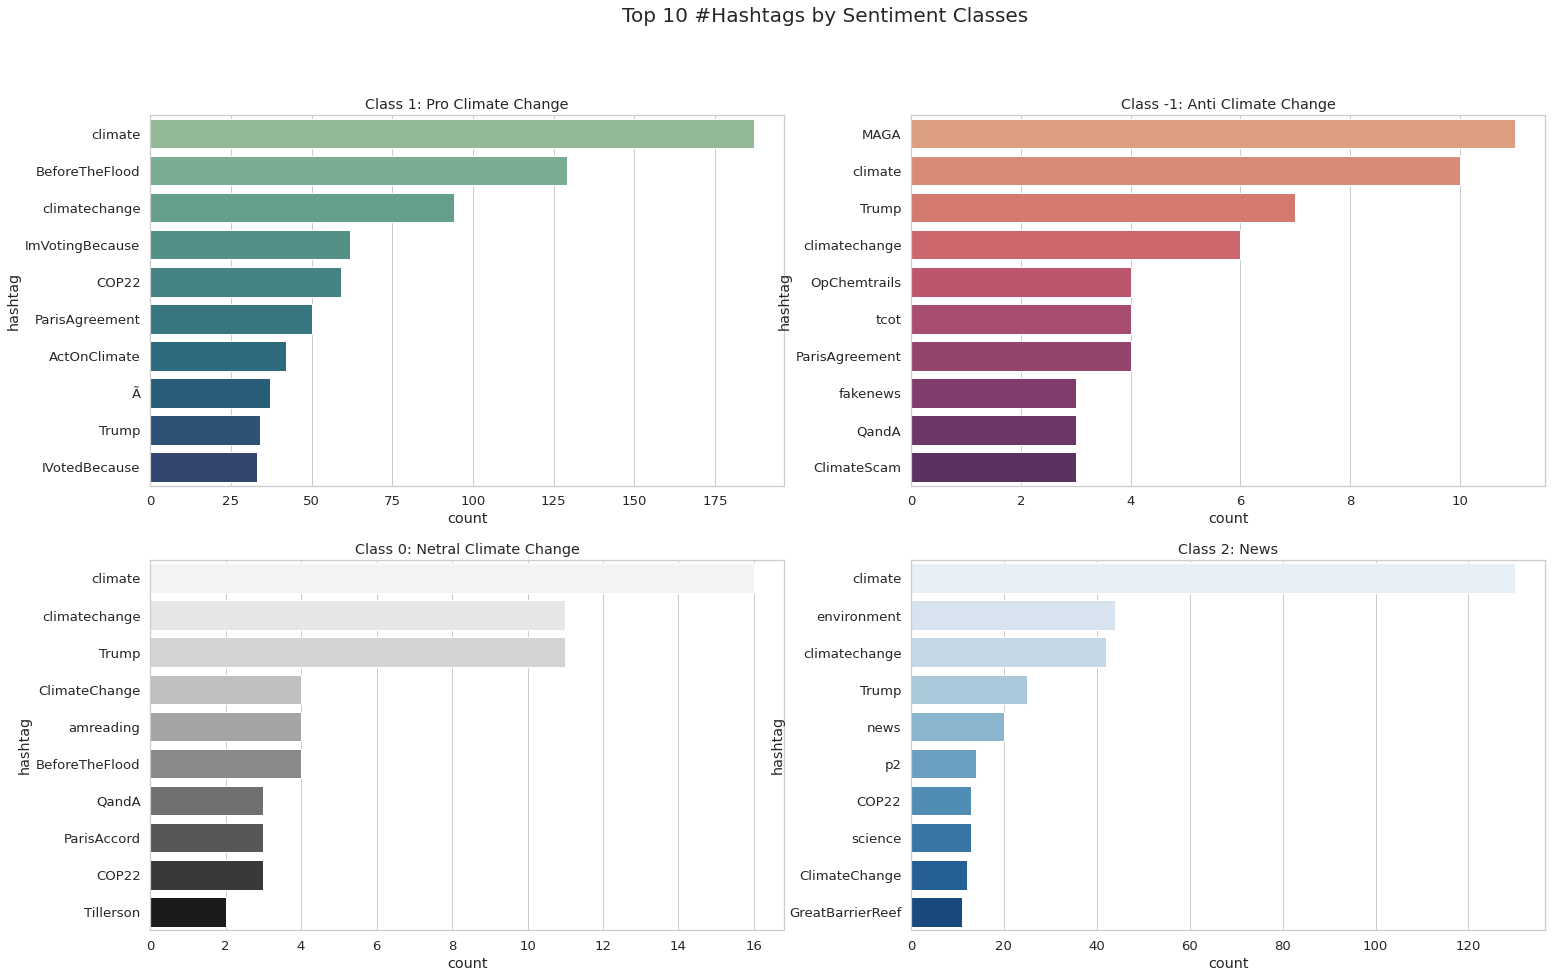

In [12]:
fig, axes = plt.subplots(2,2, figsize=(25, 15), squeeze=False)
fig.suptitle('Top 10 #Hashtags by Sentiment Classes', size=20)

sns.barplot(data=pro_has, y=pro_has['hashtag'], x=pro_has['count'], palette='crest',ax=axes[0,0])
axes[0,0].set_title("Class 1: Pro Climate Change")

sns.barplot(data=anti_has, y=anti_has['hashtag'], x=anti_has['count'], palette='flare', ax=axes[0,1])
axes[0,1].set_title("Class -1: Anti Climate Change")

sns.barplot(data=neutral_has, y=neutral_has['hashtag'], x=neutral_has['count'], palette='Greys', ax=axes[1,0])
axes[1,0].set_title("Class 0: Netral Climate Change")

sns.barplot(data=news_has, y=news_has['hashtag'], x=news_has['count'], palette='Blues', ax=axes[1,1])
axes[1,1].set_title("Class 2: News")


Hashtags are a funtion in Twitter which allows users to "tag" the topic of their interest. 
Evaluating different hashtags may provide insight on how different classes address climate change
based on certain ideas. 

- Pro climate change: 

 Besides "climate" the most popular hashtag is "BeforeTheFlood" This is a documentary hosted by actor Leo DiCaprio, which they explore the impact of man-made climate change around the world. Tweets the tags this documentary are likely agree with the existence and adverse effects of the man-made cliamte change, therefore classify as class 1. "COP22" and "Paris Agreement" were international meeting with political leaders and activists that discussed the climate change and implementation plans to combat the adverse inpact thereof. Interestingly, Donald Trump withdrew the US from the member coutry of the Paris Agreement, as he does not believe in man-made climate chage."ImVotingBecause" and "IVotedBecause" were Twitter election campaign manifested by the Democratic Party during the 45th U.S Presidential election. The Twitter user using this tag are likely the supporter of Hillary Cliton who were opposing Donald Trump at the time. This suggests that the perception of climate change of the candidate was an important factor in the political choices in the US.

- Anti climate change:

 "MAGA, also known as "Make America Great Again" was the campaign slogan used by Donald Trump during the Presidential election.The anti man-made cliamte change believers share their belief with Trump, and thereby used the hashtag intensively. Chemtrail" and "ClimateScam" reflects how anti man-made climate change believers perceive the scientific facts. Chemtrail is a conspiracy theory claiming that the condensation trails made by aircrafts are sprayed purposely to make the general public oblivious from some undisclosed information by the government. They also reject all the  
scientific consensus regarding climate change are hoax and scam to make the manipulate and suppress the general public.

- Neutral and News climate change:
 Both Neutral and News hashtags contain mix of both perspects of the climate change, but as the class name suggests
their hashtags are quite neutral.

### Mentions

In [13]:
pro_men = hash_men_ext(train_df['message'][train_df['sentiment'] == 1],r"@(\w+)")
anti_men = hash_men_ext(train_df['message'][train_df['sentiment'] == -1],r"@(\w+)")
neutral_men = hash_men_ext(train_df['message'][train_df['sentiment'] == 0],r"@(\w+)")
news_men = hash_men_ext(train_df['message'][train_df['sentiment'] == 2],r"@(\w+)")

Text(0.5, 1.0, 'Class 2: News')

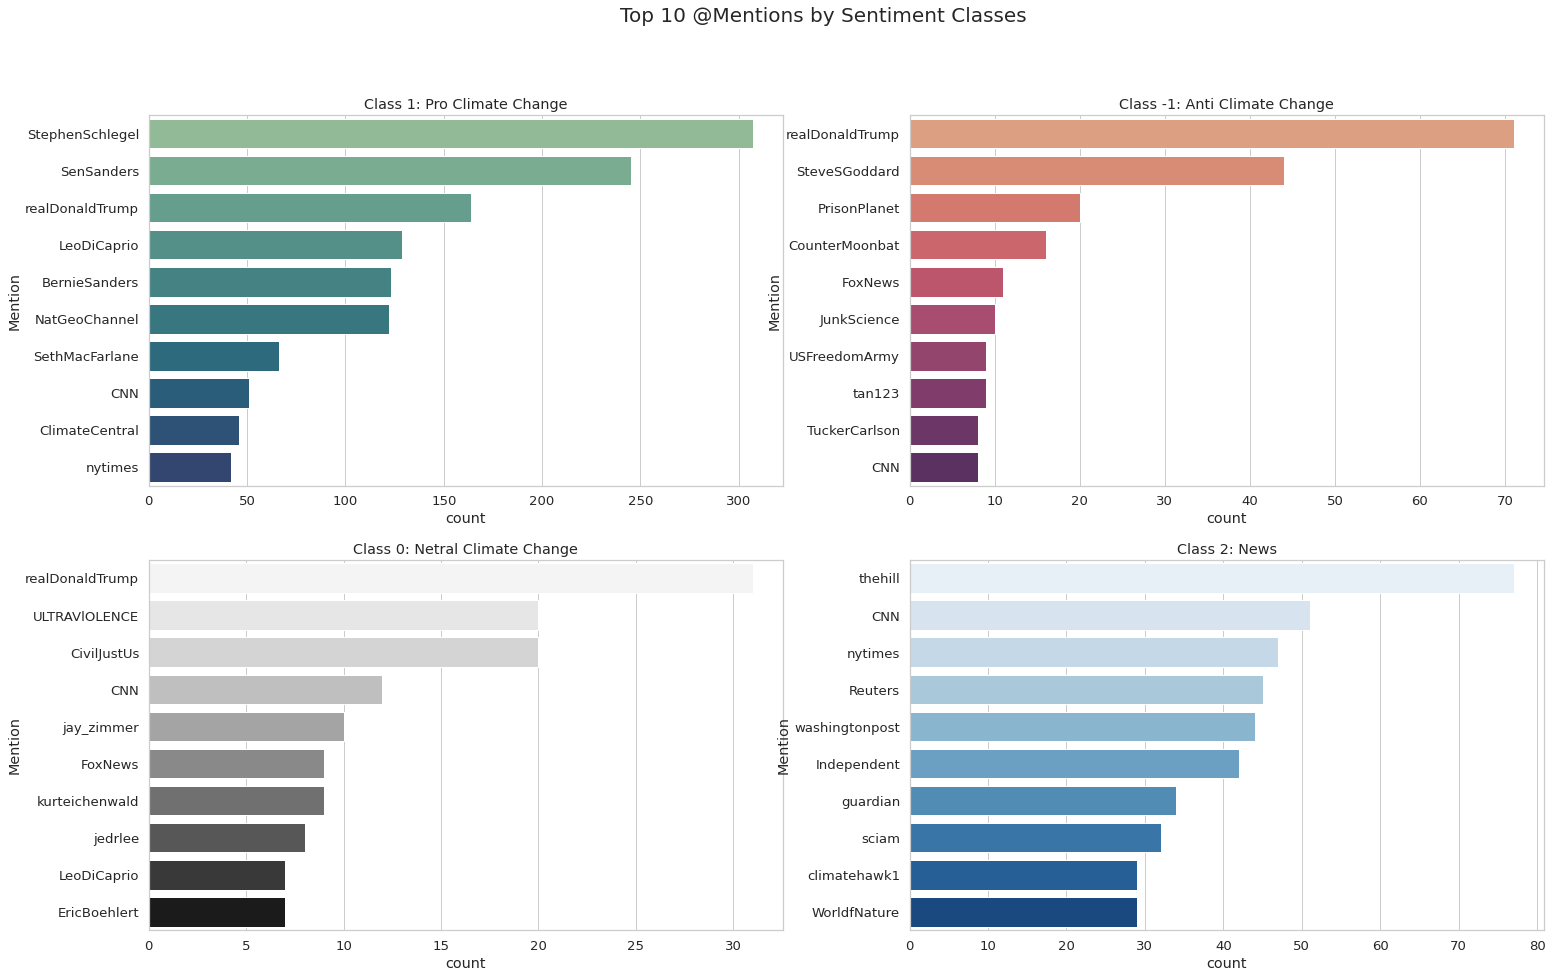

In [14]:
#sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
fig, axes = plt.subplots(2,2, figsize=(25, 15), squeeze=False)
fig.suptitle('Top 10 @Mentions by Sentiment Classes', size=20)

sns.barplot(data=pro_men, y=pro_men['Mention'], x=pro_men['count'], palette='crest', ax=axes[0,0])
axes[0,0].set_title("Class 1: Pro Climate Change")

sns.barplot(data=anti_men, y=anti_men['Mention'], x=anti_men['count'], palette='flare', ax=axes[0,1])
axes[0,1].set_title("Class -1: Anti Climate Change")

sns.barplot(data=neutral_men, y=neutral_men['Mention'], x=neutral_men['count'], palette='Greys', ax=axes[1,0])
axes[1,0].set_title("Class 0: Netral Climate Change")

sns.barplot(data=news_men, y=news_men['Mention'], x=news_men['count'],palette='Blues' , ax=axes[1,1])
axes[1,1].set_title("Class 2: News")

Hashtags are a funtion in Twitter which allows users to "tag" anothere user in their posts. Mention analysis may indicate certain group of users that share same thoughts on the topic of climate change and how their individual tweets are relatable. 

- Pro climate change: 

 "StephenSchlegal" is an interesting mention found in this class. He posted tweet replying to Melania Trump with a Beluga whale witha  caption "What is she thinking". His reply was "she's thining about how she's going to die
because your jusband doesn't believe in climate change". This tweet was so popular that it was re-tweeted countless times. Many Pro climate change figures apepar among the top mentions, Senator Bernie Sanders,  Leo DiCaprio and Seth Macfarlane. CNN and New York Times are two media favouring the Democratic party, which shares the idea of man-made climate change.

- Anti climate change:

 "realDonaldTrump", unsurprisingly, is the top mention of the anti man-made cliamte change who is the world famous non-believer of climate change."PrisonPlanet" is the Twitter account addressing conspiracy theory by Paul Watson. The anti climate change believers are likely believing that climate change is one of the many conspiracy by the government.
Similarly, the term "JunkScience" is used by the anti cliamte change believers to describe scientific data
that are fraudulent. This suggests that these users believe that the scientific research supporting the man-made climate change are spurious, manifested to undisclose information from the general public. 

- Neutral and News:
 Similar to hashtags, neutral contains mix of both pro- and anti- climate changes mentions. Most of the mentions in the news are of the Twitter accounts of the media companies.

### Proportion of Urls, Mentions, Hashtags, and Retweets

In [15]:
def proportions_df(col,symbol):
    """This function takes in a symbol and a column and returns a dataframe 
    containing the proportions of times the symbol appears in each class"""
    
    symb_df = train_df[col.str.contains(symbol)]
    a = (symb_df.groupby('sentiment').count()/train_df.groupby('sentiment').count())*100
    
    a['proportion'] = a['message']
    a.drop(['message','tweetid'],axis=1,inplace=True)
    return a 

In [16]:
url_df = proportions_df(train_df['message'],"http")
men_df = proportions_df(train_df['message'],"@")
hash_df = proportions_df(train_df['message'],"#")
rt_df =proportions_df(train_df['message'],"RT")

Text(0.5, 1.0, 'Frequency of Retweets in Tweets')

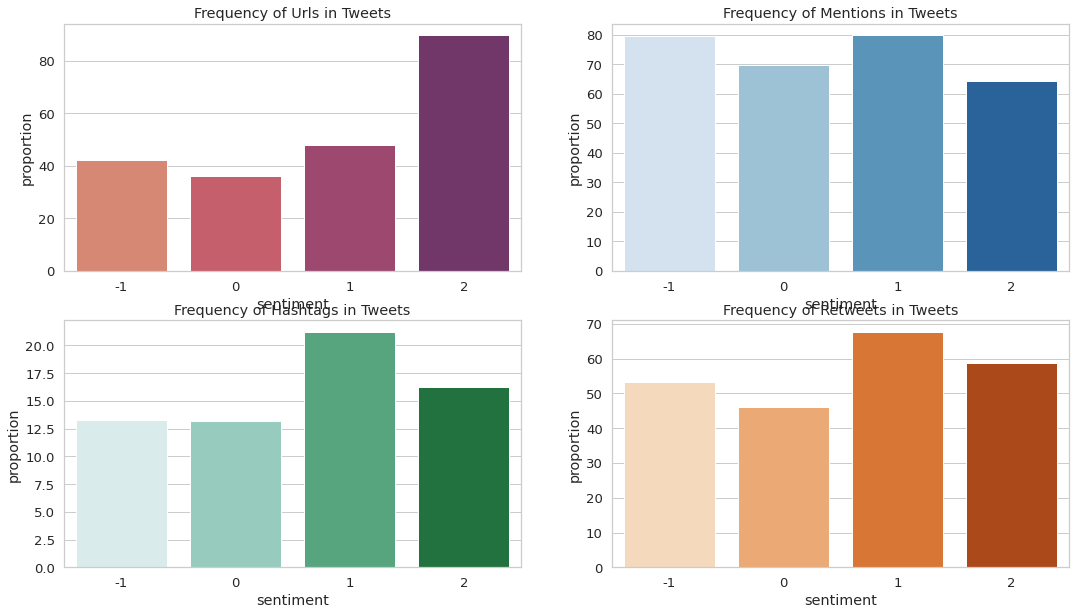

In [17]:
fig, axs = plt.subplots(2,2, figsize=(18, 10))

a = sns.barplot(x=url_df.index, y='proportion', data=url_df, ax=axs[0,0], palette='flare')
a.set_title('Frequency of Urls in Tweets')  

b = sns.barplot(x=men_df.index, y='proportion', data=men_df, ax=axs[0,1],palette='Blues')
b.set_title('Frequency of Mentions in Tweets')

c = sns.barplot(x=hash_df.index, y='proportion', data=hash_df, ax=axs[1,0],palette='BuGn')
c.set_title('Frequency of Hashtags in Tweets')

d = sns.barplot(x=rt_df.index, y='proportion', data=rt_df, ax=axs[1,1],palette='Oranges')
d.set_title('Frequency of Retweets in Tweets')


- URLs:

 The News class has the highest proportion of the URL web links in their tweets, this may be due to the fact
most of the articles are produced digitally and distributed on the web. Twitter may be used as a medium 
to share and attain more readers of these articles.

- Mentions

 Twitter mentions are highly popular among all classes but most abundant among the pro- and anti- climate change believers tweets.

- Hashtag and Retweet.

 Class 1 (pro cliamte change) has the highest hashtags and retweets. This can be reflected back to the distribution of the tweets by classes, with class 1 coonsisting more than 50% of our own dataset. Their thoughts and tweets may be widely shared with common hashtags and multiplied with retweets.

### Number of Words Distribution

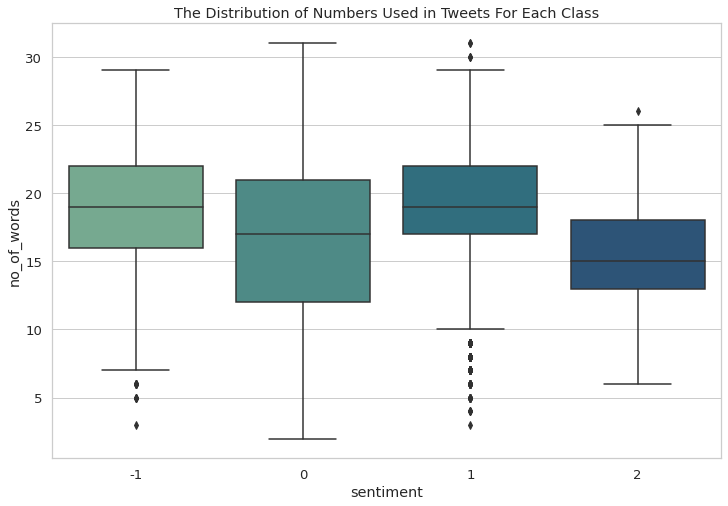

In [18]:
train_df["no_of_words"] = train_df['message'].apply(lambda x:len([i for i in x.split()]))
a = train_df[['sentiment','no_of_words']]
plt.figure(figsize=(12,8))
box = sns.boxplot(x='sentiment',y='no_of_words',data=a, palette='crest')
box.set_title('The Distribution of Numbers Used in Tweets For Each Class')
plt.show()

The news typically use less words compared to the another classes. A possible explanation for this can be found in one one of our diagrams above, most news outlets generally post headlines with links to their websites for a full coverage. Class 1(pro) and class -1(anti) appear to use equal number of words

### Length of Words Distribution

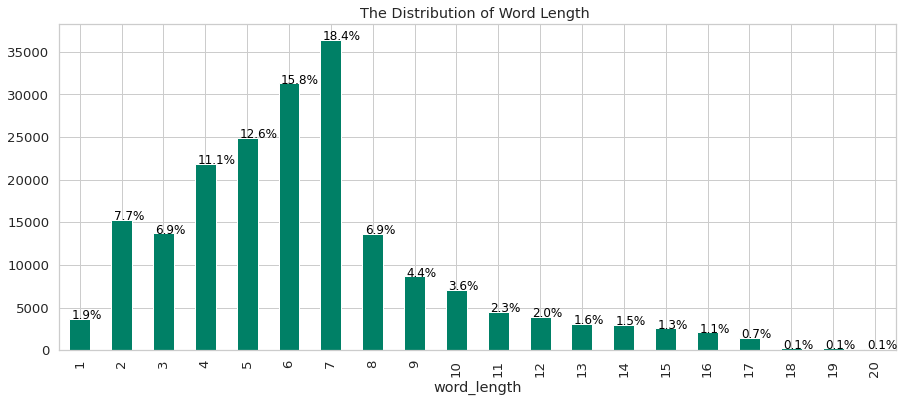

In [19]:
word_list =  train_df['message'].apply(lambda x:x.split()).values

all_words_ls=[word_list[i][j] for i in range(len(word_list)) for j in range(len(word_list[i])) if word_list[i][j] not in stopwords.words('english')]
word_length_each =pd.DataFrame([[len(i),all_words_ls.count(i)] for i in set(all_words_ls)], 
                               columns = ['word_length','frequency'])


word_length_freq = word_length_each.groupby('word_length')['frequency'].sum().head(20).plot(kind ='bar', 
                                                                                           title = "The Distribution of Word Length ", 
                                                                                           figsize = (15,6), colormap='summer')
n_obs = [i.get_height() for i in word_length_freq.patches]
total = sum(n_obs)

for i in word_length_freq.patches:
    # get_x pulls left or right; get_height pushes up or down
    word_length_freq.text(i.get_x()+0.06, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=12,
                color='black')

The lengths of the words ranged from 1-70, to obtain a better visualisation we limited the domain to words of lengths 1-2The length of the words appears to be positively skewed. We can expect the data to contain outliers to the right of the distribution. Most words lengthslie between 3-8,with the peak being 7.

# 6. Data Preprocessing

This section involves cleaning data to prepare it for our models. We defined a function which carries out the following steps:
 
* Extract emojis from text - since we're dealing with sentiment analysis emojis might contain useful information
* Replaced all urls with the word 'url'- we don't need to know the urls themselve we just need to know whether or not the text contains a link or not
* Removed all the punctuation
* Removed all the characters that are not alphabets (This deals with hashtags and mentions indirectly)
* Retrieving Base Forms involves taking words and generating their root form. One should always be caref There are 2 primary techniques for text normalisation:
 * Stemming
 * Lemmatization
 * We used Lemmatization although it's a bit slower than stemming



In [20]:
def clean_twt(text):

    # Emoji to Text
    text = emoji.demojize(text, delimiters=("", "")) 

    # Lower case-ing
    text = text.lower()

    # Replace urls
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    web = 'url'
    text = re.sub(url, web, text)

    # Remove Puncuation
    text = ''.join(i for i in text if i not in punctuation)
    
    # Removing non-alphabets
    text = re.sub('[^a-z]', ' ',text)

    # Tokenisation & Lemmatisation
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]
    text = ' '.join(text)
   
    return text

In [21]:
#Apply data cleaning function to data
train_df['clean_message'] = train_df['message'].map(clean_twt)
test_df['clean_message'] = test_df['message'].map(clean_twt)

In [22]:
train_df.head()

,sentiment,message,tweetid,no_of_words,clean_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,19,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,10,it not like we lack evidence of anthropogenic ...
2,2,RT @RawStory: Researchers say we have three ye...,698562,19,rt rawstory researcher say we have three year ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,15,todayinmaker wire wa a pivotal year in t...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,18,rt soynoviodetodas it and a racist sexist...


In [23]:
test_df.head()

,message,tweetid,clean_message
0,Europe will now be looking to China to make su...,169760,europe will now be look to china to make sure ...
1,Combine this with the polling of staffers re c...,35326,combine this with the poll of staffer re clima...
2,"The scary, unimpeachable evidence that climate...",224985,the scary unimpeachable evidence that climate ...
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,karoli morgfair osborneink dailykos putin get...
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,rt fakewillmoore female orgasm cause global wa...


# 7. Model Building

### 7.1. Train-Test Split
We first fitted our data using the dataset as it is, with imbalanced classes. We then investigated whether upsampling improves the our best model

In [24]:
X = train_df['clean_message']
y = train_df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,shuffle=True,random_state=26, stratify = y)

#### Upsampling

This involves taking the minority class and sampling it with replacement until the number of observations matches the majority class.

In [25]:
#We upsample only the training data to avoid data leakage

train_df2 = pd.DataFrame({'clean_message': X_train, 'sentiment': y_train})
test_df2 = pd.DataFrame({'clean_message': X_test, 'sentiment': y_test})

news_df  = train_df2[train_df2['sentiment'] == 2]
pro_df  = train_df2[train_df2['sentiment'] == 1]
neut_df = train_df2[train_df2['sentiment'] == 0]
anti_df = train_df2[train_df2['sentiment'] == -1]

print('Total News tweets: ', len(news_df), '\n'
        'Total Pro tweets: ', len(pro_df), '\n'
        'Total Neutral tweets: ', len(neut_df), '\n'
        'Total Anti tweets: ', len(anti_df))

# Upsampling the minority classes

news_df_up = resample(news_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

neut_df_up = resample(neut_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

anti_df_up = resample(anti_df,
                      replace = True,
                      n_samples = 8530,
                      random_state = 1)

# Concatanate the majority class and the upsampled minority classes
train_df_up = pd.concat([pro_df, news_df_up, neut_df_up, anti_df_up])

X_train_up = train_df_up['clean_message']
y_train_up = train_df_up['sentiment']


Total News tweets:  3276 
Total Pro tweets:  7677 
Total Neutral tweets:  2118 
Total Anti tweets:  1166


### 7.2. Feature Extraction

#### 7.2.1. Bag of Words
Bag of words ignores any information about the ordering or the structure of the words in our corpus. Its only concern is the occurence of the word(s). It takes in a list containing all the clean words in our corpus and returns a dictionary containing the unique words as keys and their frequencies as values. The algorithm can be configured to take in single words or take a group of words (those attained through Ngrams. The image below shows the former but the same rules apply for $n>1$.

<div style="width:100%;text-align: center;"> <img align=middle src="https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0402.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>


For each and every row, the text is going to be vectorized by in this form:
<div style="width:100%;text-align: center;"> <img align=middle src="https://www.oreilly.com/library/view/feature-engineering-for/9781491953235/assets/feml_0405.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>


#### 7.2.2. TF-IDF

Term Frequency Inverse Document Frequency is a statistic that measures how important a a word is in a document while taking into consideration how many times it appears in other documents.

The reason for doing this is:
* If a word appears in a document then it is more likely to contain information about that document
* If a word is scattered throughout the whole document it is unlikely to contain information distinguishing the various documents


The calculation tf-idf can be broken into 4 parts:
1. Calculate the term frequency: 

$$ft(w,d) = \log{\left[1+f(w,d)\right]}$$
*  Where: 
 * $f(w,d)$ measures how frequently a word $w$ appears in document $d$
2. Calculate the inverse term frequency:
$$idf(w,D) = \log{\left[\frac{N}{f(w,D)}\right]}$$
* Where:
 * $N$ is the number of documents in our corpus
 * $D$ is a set containing all the documents in our corpus
 * $f(w,D)$ is the number documents that contain $w$.
3. We combine the above to form tf-idf - Term Frequency - Inverse Document Frequency:
$$tf-idf = tf(w,d)\times idf(w,D)$$

4. Finally, we get a vectorized vesion of all the documents in our corpus


Drawbacks:
* Not able to capture semantics
# <div style="width:100%;text-align: center;"> <img align=middle src="https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/assets/atap_0404.png" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>

### 7.3. Training Individual Models


### Logistic Regression

Logistic Regression is a classification algorithm used to model the probability of belonging in a certain class. The simpliest form being a binary classifier (events with only two outcomes) but can be extended to model multi-categorical variables through methods such as one-vs-all and one-vs-one. For binary classification. The algorithm follows the same format as multiple linear regression but uses a link function to map the linear combination of predictors to a probability between [0,1]. This link function is called the logit function and it given by:
$$logit(x)=\frac{1}{1+e^{-x}}$$
The representation:


# <div style="width:100%;text-align: center;"> <img align=middle src="https://www.graphpad.com/guides/prism/latest/curve-fitting/images/hmfile_hash_38a8acae.png" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>
        
The regression equation is given by:
$$logit[P(Y=1)]=\log\left[\frac{P(Y=1)}{1-P(Y=1)}\right]=\beta_0+\beta_1x_{1i}+...+\beta_kx_{ki} +e_i$$
where:
* P(Y=1)-is the probability of belonging in class 1
* logit[P(Y=1)] the log odds of belong to class 1
*    $\beta_i$ the $i^{th}$ coefficient 

In [26]:
# GridSearch Result: {'clf__C': 10, 'clf__max_iter': 1000, 'tfidf__max_df': 0.9, 'tfidf__min_df': 0}

lr1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', LogisticRegression(max_iter=300))])

#Logistic Regression
lr1.fit(X_train, y_train)
y_pred_lr1 = lr1.predict(X_test)

f1_lr1 =f1_score(y_test,y_pred_lr1,average='weighted')
f1_lr1

0.7235284674765898

In [27]:
lr2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', LogisticRegression(max_iter=300))])

#Logistic Regression
lr2.fit(X_train, y_train)
y_pred_lr2 = lr2.predict(X_test)

f1_lr2 =f1_score(y_test,y_pred_lr2,average='weighted')
f1_lr2

0.7579833220083103

#### Linear Support Vector Regression

The objective of Support Vector Classification fit an N-dimensional hyperplane that maximally seperates classes. The mathematical representation of this model is beyond the scope of this project. Below is a figure of the the intuition explained above.

# <div style="width:100%;text-align: center;"> <img align=middle src="https://miro.medium.com/max/1088/1*6U9NrruycDBsPOyivpn8UQ.png" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>

In [28]:
lsvc1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                           ngram_range=(1,2))), 
                 ('clf', LinearSVC())])

#Linear Support Vector Classifier
lsvc1.fit(X_train, y_train)
y_pred_lsvc1 = lsvc1.predict(X_test)


f1_lsvc1 =f1_score(y_test,y_pred_lsvc1,average='weighted')
f1_lsvc1

0.7542407131981888

In [29]:
lsvc2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                           ngram_range=(1,2))), 
                 ('clf', LinearSVC())])

#Linear Support Vector Classifier
lsvc2.fit(X_train, y_train)
y_pred_lsvc2 = lsvc2.predict(X_test)


f1_lsvc2 =f1_score(y_test,y_pred_lsvc2,average='weighted')
f1_lsvc2

0.7474534047910525

#### Decision Tree Classifier

Decision trees classify the examples by sorting them down the tree from the root to some leaf/terminal node, with the leaf/terminal node providing the classification of the example.

Each node in the tree acts as a test case for some attribute, and each edge descending from the node corresponds to the possible answers to the test case. This process is recursive in nature and is repeated for every subtree rooted at the new node.

 

Assumptions while creating Decision Tree
 
Below are some of the assumptions we make while using Decision tree:

In the beginning, the whole training set is considered as the root.
Feature values are preferred to be categorical. If the values are continuous then they are discretized prior to building the model.
Records are distributed recursively on the basis of attribute values.
Order to placing attributes as root or internal node of the tree is done by using some statistical approach.

Drawback: Prone to overfitting
# <div style="width:100%;text-align: center;"> <img align=middle src="https://www.tutorialspoint.com/machine_learning_with_python/images/decision_tree_introduction.jpg" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>

In [30]:
dt1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.9,
                                            ngram_range=(1,2))), 
               ('clf', DecisionTreeClassifier())])

#Decision Tree Classifer
dt1.fit(X_train, y_train)
y_pred_dt1 = dt1.predict(X_test)


f1_dt1 =f1_score(y_test,y_pred_dt1,average='weighted')
f1_dt1

0.6026183195125004

In [31]:
dt2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.9,
                                            ngram_range=(1,2))), 
               ('clf', DecisionTreeClassifier())])

#Decision Tree Classifer
dt2.fit(X_train, y_train)
y_pred_dt2 = dt2.predict(X_test)

f1_dt2 =f1_score(y_test,y_pred_dt2,average='weighted')
f1_dt2

0.661143164530109

#### Random Forest Classifier

Random Forest Classification is an ensemble method that combines multiple decision tree. It trains multiple decision trees on different subsets of the data and the combine the results through a method called bagging to produce more stable predictions  compared to a single decision tree.

# <div style="width:100%;text-align: center;"> <img align=middle src="https://najeesmith.github.io/images/Classifiers/RF/header.png" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>

In [32]:
rf1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', RandomForestClassifier())])

#Random Forest Classifier
rf1.fit(X_train, y_train)
y_pred_rf1 = rf1.predict(X_test)

f1_rf1 =f1_score(y_test,y_pred_rf1,average='weighted')
f1_rf1

0.6875265405183857

In [33]:
rf2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
               ('clf', RandomForestClassifier())])

#Random Forest Classifier
rf2.fit(X_train, y_train)
y_pred_rf2 = rf2.predict(X_test)

f1_rf2 =f1_score(y_test,y_pred_rf2,average='weighted')
f1_rf2

0.6984214002045509

#### K-Nearest Neighbors

This is a non-parametric classification algorithm/ The basic idea is that you input a known data set, add an unknown, and the algorithm will tell you to which class that unknown data point belongs. The unknown is classified by a simple neighborly vote, where the class of close neighbors wins. The k represents the number of 'neighbors' that we consider when calculating our distances.

# <div style="width:100%;text-align: center;"> <img align=middle src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" alt="Heat beating" style="height:400px;margin-top:3rem;"> </div>



In [34]:
knn1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))),  
                ('clf', KNeighborsClassifier())])

# K-Nearest Neighbors Classifier
knn1.fit(X_train, y_train)
y_pred_knn1 = knn1.predict(X_test)

f1_knn1 =f1_score(y_test,y_pred_knn1,average='weighted')
f1_knn1

0.6514788922096404

In [35]:
knn2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))),  
                ('clf', KNeighborsClassifier())])

# K-Nearest Neighbors Classifier
knn2.fit(X_train, y_train)
y_pred_knn2 = knn2.predict(X_test)

f1_knn2 =f1_score(y_test,y_pred_knn2,average='weighted')
f1_knn2

0.42366122260514444

#### Multinomial Naive Bayes Classifier

This a classification algorithm is based on Bayes Theorem. It assumes that the predictor(explanatory) variable are independent from each other. In order to make predictions it makes use of the posterior distribution (probability of belonging in a certain class given the data) to make class predictions. When we have n predictors our class probability is:
$$P(c|x_1,...,x_n)=\frac{p(x_1|c)\times p(x_2|c)\times...\times p(x_n|c)\times p(c)}{p(x_1)\times p(x_2)\times ...\times p(x_n)}$$

* $P(c|x_1,...,x_n)$ is the posterior distribution 
* p(x_i|c) the probability of observing x_i given the class c
* p(x_i) probability observing x_i

In [36]:
mnnb1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', MultinomialNB())])

# Multinomial NB Classifier
mnnb1.fit(X_train, y_train)
y_pred_mnnb1 = mnnb1.predict(X_test)

f1_mnnb1=f1_score(y_test,y_pred_mnnb1,average='weighted')
f1_mnnb1

0.5593410867337707

In [37]:
mnnb2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', MultinomialNB())])

# Multinomial NB Classifier
mnnb2.fit(X_train, y_train)
y_pred_mnnb2 = mnnb2.predict(X_test)

f1_mnnb2=f1_score(y_test,y_pred_mnnb2,average='weighted')
f1_mnnb2

0.6869941996496454

#### Stochastic Gradient Descent Classifier

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

In [38]:
sgd1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', SGDClassifier())])

# SGD Classifier
sgd1.fit(X_train, y_train)
y_pred_sgd1 = sgd1.predict(X_test)

f1_sgd1=f1_score(y_test,y_pred_sgd1,average='weighted')
f1_sgd1

0.7327796417017484

In [39]:
sgd2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', SGDClassifier())])
# SGD Classifier
sgd2.fit(X_train, y_train)
y_pred_sgd2 = sgd2.predict(X_test)

f1_sgd2=f1_score(y_test,y_pred_sgd2,average='weighted')
f1_sgd2

0.7511181797011869

#### AdaBoost Classifier
It works in the following way:

- Initially, Adaboost selects a training subset randomly.

- It iteratively trains the AdaBoost machine learning model by selecting the training set based on the accurate prediction of the last training.
- It assigns the higher weight to wrong classified observations so that in the next iteration these observations will get the high probability for classification.
- Also, It assigns the weight to the trained classifier in each iteration according to the accuracy of the classifier. The more accurate classifier will get high weight.
- This process iterate until the complete training data fits without any error or until reached to the specified maximum number of estimators.
- To classify, perform a "vote" across all of the learning algorithms you built.

In [40]:
ada1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', AdaBoostClassifier())])
# Adaboost Classifier
ada1.fit(X_train, y_train)
y_pred_ada1 = ada1.predict(X_test)


f1_ada1 = f1_score(y_test,y_pred_ada1,average='weighted')
f1_ada1 

0.5997398339923524

In [41]:
ada2 = Pipeline([('BoW', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', AdaBoostClassifier())])

# Adaboost Classifier
ada2.fit(X_train, y_train)
y_pred_ada2 = ada2.predict(X_test)

f1_ada2 = f1_score(y_test,y_pred_ada2,average='weighted')
f1_ada2

0.6179723790321594

#### Gradient Boosting

This is a generalisation of Adaboost

In [42]:
gbc1 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', GradientBoostingClassifier())])

# Gradient Boost Classifier
gbc1.fit(X_train, y_train)
y_pred_gbc1 = gbc1.predict(X_test)

f1_gbc1= f1_score(y_test,y_pred_gbc1,average='weighted')
f1_gbc1

0.6435665060718163

In [43]:
gbc2 = Pipeline([('BoW',CountVectorizer(stop_words='english',
                                            min_df=0,
                                            max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', GradientBoostingClassifier())])

# Gradient Boost Classifier
gbc2.fit(X_train, y_train)
y_pred_gbc2 = gbc2.predict(X_test)

f1_gbc2= f1_score(y_test,y_pred_gbc2,average='weighted')
f1_gbc2

0.6340912025119152

# 8. Model Comparison

## Evaluation Metric

We will start by defining a couple of terms that make up the f1 score:
* Precision - measures the proportion of positive identifications that are actually correct. It is a good measure for situations where the cost of false positive is high(e.g spam email)
* Recall (Sensitivity) - measures the proportion of actual positives that are identified correctly. It is a good measure for situations where the cost of a false negative is high (e.g. cancer detection)
* F1 score is the harmonic mean of precision and recall. Just like precision and recall it is a value between 0 and 1 with numbers closer to 1 indicate a better fit.
$$f-1_{score}=2\times\frac{precision\times recall}{precision+recall}$$
* For classification problems with more than 2 labels, we have a couple of choices. We won't go over therm but we are going to use the weighted f1-score. Which  the average considering the proportion for each label in the dataset. 




In [44]:
f1_score_tfidf = [f1_lr1,
                  f1_lsvc1,
                  f1_dt1,
                  f1_rf1,
                  f1_knn1,
                  f1_mnnb1,
                  f1_sgd1,
                  f1_ada1,
                  f1_gbc1]

f1_score_bow = [f1_lr2,
                  f1_lsvc2,
                  f1_dt2,
                  f1_rf2,
                  f1_knn2,
                  f1_mnnb2,
                  f1_sgd2,
                  f1_ada2,
                  f1_gbc2]

model_list = ['Logistic Regression', 
            'Linear SVC',
            'Decision Tree',
            'Random Forest',
            'K-Nearest Neighbours', 
            'Multinomial Naive Bayes',  
            'SGD Classifier', 
            'Adaboost', 
            'GradientBoosting']
f1_scores = pd.DataFrame(list(zip(model_list, f1_score_tfidf,f1_score_bow)), 
                         columns=['Model','TF-IDF','BoW'])
f1_scores

,Model,TF-IDF,BoW
0,Logistic Regression,0.723528,0.757983
1,Linear SVC,0.754241,0.747453
2,Decision Tree,0.602618,0.661143
3,Random Forest,0.687527,0.698421
4,K-Nearest Neighbours,0.651479,0.423661
5,Multinomial Naive Bayes,0.559341,0.686994
6,SGD Classifier,0.732780,0.751118
7,Adaboost,0.599740,0.617972
8,GradientBoosting,0.643567,0.634091


In [45]:
df1 = pd.melt(f1_scores, id_vars=['Model'],value_vars=["TF-IDF","BoW"])

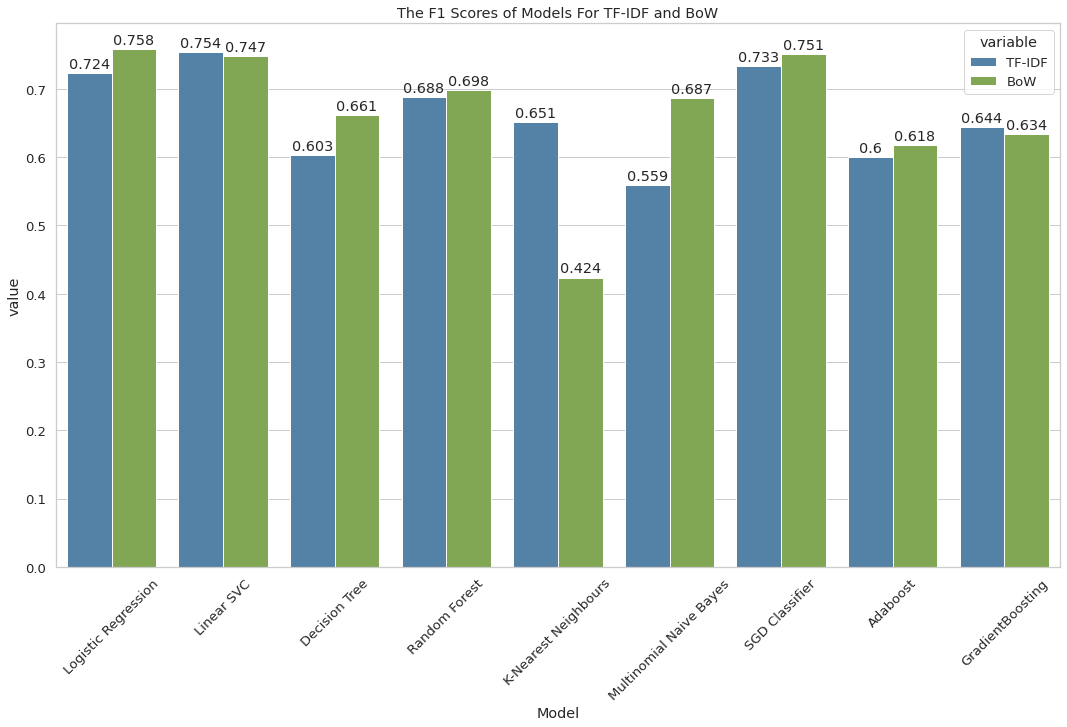

In [46]:
fig = plt.figure(figsize=(18, 10))

bplot = sns.barplot(x='Model', y='value', hue='variable', palette=["steelblue","#82B446"], data=df1)
for p in bplot.patches:
    bplot.annotate(format(round(p.get_height(),3)),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

bplot.set_xticklabels(bplot.get_xticklabels(), rotation=45)
plt.title('The F1 Scores of Models For TF-IDF and BoW')
plt.show()

### Results
- CountVectorizer outperformed Tf-idf over Logistic Regression, Decision Trees, Random Forest, Multinomial Naive Bayes, SGD Classifier,and Adaboost (6 out of 9 models)
- Linear Models (Logistic, LinearSVC, SGD) outperformed all the other models.
- K-Nearest Neighbors (with countvectorizer) produced the worst fit with an f1 score of 0.424.
- The best performing model: Logistic Regression with countvectorize.

# 9. Model Optimisation

## Stacking Top 3 Models

We stacked the best 3 models namely: 
- Logistic Regression 
- Linear SVC
- SGD 

In [47]:
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(C=10, max_iter=1000)))
level0.append(('lsvc', LinearSVC(C=0.5, max_iter=100)))
level0.append(('sgd', SGDClassifier(alpha=0.0001, max_iter=10000)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

We fitted the above model, with both Tf-idf and Bag of words

In [48]:
stack = Pipeline([('tfidf', TfidfVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', model)])

# SGD Classifier
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

print('Model: Stacking Classifier')
print(classification_report(y_test, y_pred_stack))

Model: Stacking Classifier
              precision    recall  f1-score   support

          -1       0.69      0.62      0.65       130
           0       0.65      0.43      0.52       235
           1       0.80      0.87      0.84       853
           2       0.76      0.79      0.78       364

    accuracy                           0.77      1582
   macro avg       0.73      0.68      0.70      1582
weighted avg       0.76      0.77      0.76      1582



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

          -1       0.69      0.62      0.65       130
           0       0.65      0.43      0.52       235
           1       0.80      0.87      0.84       853
           2       0.76      0.79      0.78       364

    accuracy                           0.77      1582
   macro avg       0.73      0.68      0.70      1582
weighted avg       0.76      0.77      0.76      1582



In [50]:
print(f1_score(y_test, y_pred_stack, average='weighted'))

0.760813092695289


Stacking increased our f1_score to 0.761.

In [51]:
stack1 = Pipeline([('bow', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', model)])

# SGD Classifier
stack1.fit(X_train, y_train)
y_pred_stack1 = stack1.predict(X_test)

print('Model: Stack Classifier tfidf')
print(classification_report(y_test, y_pred_stack1))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Model: Stack Classifier tfidf
              precision    recall  f1-score   support

          -1       0.73      0.59      0.65       130
           0       0.65      0.42      0.51       235
           1       0.77      0.90      0.83       853
           2       0.81      0.74      0.77       364

    accuracy                           0.77      1582
   macro avg       0.74      0.66      0.69      1582
weighted avg       0.76      0.77      0.76      1582



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [52]:
print(f1_score(y_test, y_pred_stack1, average='weighted'))

0.7551920719339814


Count vectorizer marginally outperformed tf-idf on the stacked model and it is therefore our best model.


# Upsampling

We investigated the effect that upsampling has on the fit. We only do this for the best model (Stacking with count vectorizer).

In [53]:
stack3 = Pipeline([('bow', CountVectorizer(stop_words='english',
                                                min_df=0,
                                                max_df=0.8,
                                            ngram_range=(1,2))), 
                ('clf', model)])

# SGD Classifier
stack3.fit(X_train_up, y_train_up)
y_pred_stack3 = stack3.predict(X_test)

print('Model: Stack Classifier Count Vectorizer')
print(classification_report(y_test, y_pred_stack3))

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Model: Stack Classifier Count Vectorizer
              precision    recall  f1-score   support

          -1       0.84      0.41      0.55       130
           0       0.75      0.25      0.38       235
           1       0.69      0.95      0.80       853
           2       0.84      0.62      0.72       364

    accuracy                           0.73      1582
   macro avg       0.78      0.56      0.61      1582
weighted avg       0.75      0.73      0.70      1582



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Upsamping the minority classes reduced the f1 score from 0.76 to 0.70.

# 10. Conclusion
More than half of the tweets in the dataset were in support of the man-made cliamte change. The most interesting insights provided by the explanatory data analysis is that climate change is not only a scientific controversy, but an important polarizer among the U.S. politics.  The majority of the anti-belief in climate change come from the supporters of the Republican party and former president Donald Trump. Another common aspect of the tweets across all classes was that the tweets contained URL webs, suggesting that Twitter is used as a medium to share information by the general public. Interestingly, the some of the most popular Hashtags and Mentions used by the anti-believers are users and accounts that address conspiracy theories. This indicates that these group of users regard climate change as one of many conspiracy manifested by the governments to leave the general public oblivious to certain information. Former president Donald Trump was in the centre of the topic across all classes, appearing frequently in pro-, anti- and neutral-belief tweets. This is not surprising as he has been the controversial figure in the topic of climate change.


Initially we created 9 models and found the linear models to be the best performing. We Stacked the  best 3 linear model and this produced a model with an F1 score (0.764) that is better than then individual models. We studied the effect of upsampling the training set and found it to produce a worse fit. All of the above insights can be further explored via our Streamlit App: The insights and information gained from the Climate Change Sentiment analysis may provide an accurate and specialised solution for companies/institutions regarding their marketing strategies across wide demographical populations.